In [55]:
import numpy as np
import sklearn
import os
import pandas as pd
import scipy
from sklearn.linear_model import LinearRegression
import sklearn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [56]:
#!pip install line_profiler

In [57]:
os.chdir("/content/drive/MyDrive/Winter_Research")

In [3]:
def load():  
  X = np.loadtxt("Full_Model_2_X.csv", delimiter=',').reshape((137, 5711, 11, 3))
  y = np.loadtxt("Full_Model_2_Y.csv", delimiter=',')
  return X, y

In [53]:
X, y = load()

In [5]:
y_baseline = np.loadtxt("Baseline_Y.csv", delimiter=',')

In [58]:
print(torch.cuda.device_count())
cuda0 = torch.device('cuda:0')


1


In [60]:
#Train, test, val, split
# 41
X_train_t, X_test, y_train_t, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train_t, y_train_t, test_size=0.1, random_state=40)

#To tensors
X_train = torch.as_tensor(X_train, device=cuda0, dtype=torch.float)
X_test = torch.as_tensor(X_test, device=cuda0, dtype=torch.float)
X_val = torch.as_tensor(X_val, device=cuda0, dtype=torch.float)
y_train = torch.as_tensor(y_train, device=cuda0, dtype=torch.float)
y_val = torch.as_tensor(y_val, device=cuda0, dtype=torch.float)
y_test = torch.as_tensor(y_test, device=cuda0, dtype=torch.float)

#Reshape y
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)
y_val = y_val.reshape(y_val.shape[0], 1)

In [61]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

torch.Size([98, 5711, 11, 3]) torch.Size([98, 1]) torch.Size([11, 5711, 11, 3]) torch.Size([11, 1]) torch.Size([28, 5711, 11, 3]) torch.Size([28, 1])


In [62]:
X_train = X_train.permute(0, 3, 1, 2)
X_val = X_val.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

# PyTorch Model

In [63]:
X_train.shape

torch.Size([98, 3, 5711, 11])

In [92]:
class Net(nn.Module):
  def __init__(self, num_classes=10):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()

    self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()

    # self.pool = nn.MaxPool2d(kernel_size=2)

    # self.conv3 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1)
    # self.relu3 = nn.ReLU()

    # self.conv4 = nn.Conv2d(in_channels=50, out_channels=10, kernel_size=3, stride=1, padding=1)
    # self.relu4 = nn.ReLU()

    self.conv5 = nn.Conv2d(in_channels=10, out_channels=100, kernel_size=3, stride=1, padding=1)
    self.relu5 = nn.ReLU()

    self.fc1 = nn.Linear(in_features=62821*10, out_features=100)
    self.relu6 = nn.ReLU()
    self.fc2 = nn.Linear(in_features=100, out_features=50)
    self.relu7 = nn.ReLU()
    self.fc3 = nn.Linear(in_features=50, out_features=1)

  def forward(self, input):
    output = self.conv1(input)
    output = self.relu1(output)

    output = self.conv2(output)
    output = self.relu2(output)

    # output = self.pool(output)

    # output = self.conv3(output)
    # output = self.relu3(output)

    # output = self.conv4(output)
    # output = self.relu4(output)

    # output = self.conv4(output)
    # output = self.relu4(output)
    #print(output.shape)
    output = output.reshape(-1, 62821*10)
    #print(output.shape)
    output = self.fc1(output)
    output = self.relu6(output)
    #print(output.shape)
    output = self.fc2(output)
    output = self.relu7(output)
    output = self.fc3(output)
    #print(output.shape)

    return output
model = Net()
model = model.cuda()

In [93]:
torch.cuda.empty_cache()

In [94]:
X_train.shape

torch.Size([98, 3, 5711, 11])

In [95]:
batches_x = [X_train[:20], X_train[20:40], X_train[40:60], X_train[60:80], X_train[80:100]]
batches_y = [y_train[:20], y_train[20:40], y_train[40:60], y_train[60:80], y_train[80:100]]

In [ ]:
del optimizer
del criterion
torch.cuda.empty_cache()


In [96]:
criterion = nn.MSELoss()
model.to('cuda:0')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [97]:
train_loss = []
val_loss = []

In [202]:
epochs = 100
loss_arr = []
for i in range(epochs):
  loss_tot = 0
  #for j in range(X_train.shape[0]):
  for batch_x, batch_y in zip(batches_x, batches_y):  
    y_hat = model.forward(batch_x)
  #print("y_hat", y_hat.shape, y_hat)
  #print("y_train", y_train)
  #break
    loss = criterion(y_hat, batch_y)
    loss_arr.append(loss)
    loss_tot += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  with torch.no_grad():
    y_hat_t = model.forward(X_val)
    loss_v = criterion(y_hat_t, y_val)
    val_loss.append(loss_v.item())
  if i % 10 == 0:
    print(f'Epoch: {i} Train Loss: {loss_tot // 6} " Val Loss: "{loss_v}')
    train_loss.append(int(loss_tot // 6))

Epoch: 0 Train Loss: 9713.0 " Val Loss: "505448.96875
Epoch: 10 Train Loss: 10866.0 " Val Loss: "491039.09375
Epoch: 20 Train Loss: 7148.0 " Val Loss: "508962.0
Epoch: 30 Train Loss: 7931.0 " Val Loss: "512373.59375
Epoch: 40 Train Loss: 5154.0 " Val Loss: "497068.5
Epoch: 50 Train Loss: 8210.0 " Val Loss: "505826.59375
Epoch: 60 Train Loss: 6633.0 " Val Loss: "469831.0
Epoch: 70 Train Loss: 3118.0 " Val Loss: "487324.25
Epoch: 80 Train Loss: 2788.0 " Val Loss: "502048.0
Epoch: 90 Train Loss: 8496.0 " Val Loss: "490557.5


In [203]:
preds = []
with torch.no_grad():
  y_hat_t = model.forward(X_test)
  loss = criterion(y_hat_t, y_test)
  val_loss.append(loss.item())
  print(loss.item())
  #preds.append(y_hat.argmax().item())

96945.9609375


In [ ]:
min(val_loss)

525406.375

In [ ]:
plt.plot(range(len(train_loss[10:])), train_loss[4:])
plt.plot(range(len(val_loss[4:])), val_loss[4:])
plt.legend(["Train Loss", "Val Loss"])
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
#plt.savefig("Train_Test.png")
plt.show()

In [ ]:
test_loss = test_loss*10

In [ ]:
y_test_mean = torch.Tensor([2425]*10).reshape(10, 1)

In [ ]:
y_test_mean

In [ ]:
y_hat_t

In [ ]:
l = criterion(y_test.cpu()[3], y_test_mean[3])

In [ ]:
l

tensor(555025.)

0.9406691641646536


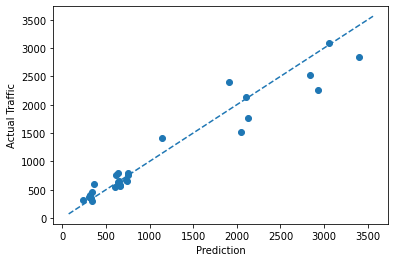

In [191]:
x_temp = y_test.cpu()
y_temp = y_hat_t.cpu()
x_plot = np.array(y_temp)
y_plot = np.array(x_temp)
new_x = np.array(x_plot).reshape(-1,1)
new_y = np.array(y_plot)
fit = LinearRegression().fit(new_x, new_y)
score = fit.score(new_x, new_y)
plt.xlabel("Prediction")
plt.ylabel("Actual Traffic")
print(score)
plt.scatter(new_x, new_y)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = x_vals
plt.plot(x_vals, y_vals, '--')
#plt.savefig("CNN_fire.png")
plt.show()

In [ ]:
# 0.945, 0.830
# MSE 88, 914, 76

#0.950
#MSE 63,443

In [ ]:
X_test

In [ ]:
y_hat

In [ ]:
torch.cuda.memory_summary(device=0, abbreviated=False)

In [ ]:
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

In [32]:
s = y_train[y_train[:, 1] == 5]

In [ ]:
s

In [34]:
np.mean(s[:, 0])

477.6363636363636

In [45]:
preds = {}
for i in range(1, 6):
  select = y_train[y_train[:, 1] == i]
  preds[i] = np.mean(select[:, 0])

In [46]:
preds

{1: 2504.5172413793102,
 2: 772.2962962962963,
 3: 306.4375,
 4: 732.2631578947369,
 5: 461.7142857142857}

In [ ]:
y_test

In [47]:
x = []
y = []
mse = 0
for i in range(y_test.shape[0]):
  x.append(preds[y_test[i][1]])
  y.append(y_test[i][0])
  mse += (preds[y_test[i][1]] - y_test[i][0])**2

In [48]:
mse / len(y_test)

99098.89435494575

0.8734442268681637


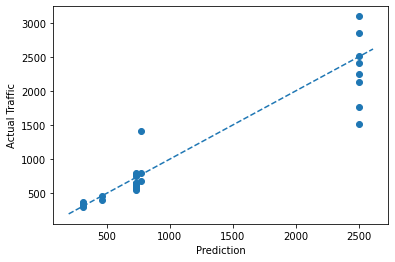

In [50]:
x_plot = np.array(x)
y_plot = np.array(y)
new_x = np.array(x_plot).reshape(-1,1)
new_y = np.array(y_plot)
fit = LinearRegression().fit(new_x, new_y)
score = fit.score(new_x, new_y)
plt.xlabel("Prediction")
plt.ylabel("Actual Traffic")
print(score)
plt.scatter(new_x, new_y)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = x_vals
plt.plot(x_vals, y_vals, '--')
plt.savefig("Baseline.png")
plt.show()

In [ ]:
# 0.873
# 99098